In [ ]:
import os
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np
from typing import List, Tuple
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from supervision import Detections
from PIL import Image

def resize_image(image, max_size=1024):
    
    # Get original dimensions
    original_width, original_height = image.size
    
    # If image is already smaller than max_size, return as-is
    if original_width <= max_size and original_height <= max_size:
        return image
    
    # Calculate the scaling factor
    if original_width > original_height:
        # Width is the limiting dimension
        new_width = max_size
        new_height = int((original_height * max_size) / original_width)
    else:
        # Height is the limiting dimension
        new_height = max_size
        new_width = int((original_width * max_size) / original_height)
    
    # Resize using high-quality resampling
    resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    return resized_image



def list_images_in_folder(folder_path):
    """
    List all image files in a folder
    
    Args:
        folder_path (str): Path to the folder
        
    Returns:
        list: List of image file paths
    """
    folder = Path(folder_path)
    
    # Supported image extensions
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif', '.webp'}
    
    image_files = []
    for file_path in folder.iterdir():
        if file_path.is_file() and file_path.suffix.lower() in image_extensions:
            image_files.append(str(file_path))
    
    return sorted(image_files)

def draw_bbox_on_image(pil_image, bbox, color='red', thickness=3):
    # Create a copy of the image
    image_copy = pil_image.copy()
    draw = ImageDraw.Draw(image_copy)
    
    # Draw the bounding box
    for i in range(thickness):
        draw.rectangle(
            bbox,
            outline=color,
            fill=None
        )
    
    return image_copy

# Load model once (outside the function)
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")
model = YOLO(model_path)

def detect_faces(pil_image):
    output = model(pil_image)
    results = Detections.from_ultralytics(output[0])
    return results.xyxy

def crop_face(pil_image, bbox):
    return pil_image.crop(bbox)

def checkvertical(bbox):
    return bbox[3]-bbox[1] > bbox[2]-bbox[0]

def make_square(bbox):
    center = (bbox[0] + bbox[2]) / 2
    height = 1.3 * (bbox[3] - bbox[1])
    bbox[0], bbox[2] = center - height, center + height
    bbox[1] = 0
    bbox[3] += height / 10
    return bbox

def draw_on_bbox(pil_image, bbox):
    draw = ImageDraw.Draw(pil_image)
    draw.rectangle([(bbox[0], bbox[1]), (bbox[2], bbox[3])], fill='black')
    return pil_image

def get_subfolders(parent_folder):
    """
    Get all subfolders within a parent directory
    
    Args:
        parent_folder (str): Path to the parent folder
        
    Returns:
        list: List of subfolder paths
    """
    parent_path = Path(parent_folder)
    subfolders = [str(subfolder) for subfolder in parent_path.iterdir() if subfolder.is_dir()]
    return sorted(subfolders)

def process_folders(folder_list):
    """
    Process multiple folders for face detection and cropping
    
    Args:
        folder_list (list): List of folder paths to process
    """
    for folder in folder_list:
        print(f"Processing folder: {folder}")
        
        # Create output directory
        folder_name = Path(folder).name
        output_dir = Path("dataset") / folder_name
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Get all images in the folder
        images = list_images_in_folder(folder)
        
        for imgpath in images:
            try:
                image = Image.open(imgpath)
                bboxes = detect_faces(image)
                
                # Skip if more than one face detected
                if len(bboxes) > 1:
                    print(f"  Skipping {imgpath}: Multiple faces detected")
                    continue
                
                # Skip if no faces detected
                if len(bboxes) == 0:
                    print(f"  Skipping {imgpath}: No faces detected")
                    continue
                
                bbox = bboxes[0]
                
                # Skip if not vertical
                if not checkvertical(bbox):
                    print(f"  Skipping {imgpath}: Face not vertical")
                    continue
                
                bbox = make_square(bbox)
                
                # Create cropped and painted images
                cropped = crop_face(image, bbox)
                painted = draw_on_bbox(image.copy(), bbox)
                
                # Generate output filenames
                img_name = Path(imgpath).stem
                img_ext = Path(imgpath).suffix
                
                cropped_filename = f"{img_name}_cropped{img_ext}"
                painted_filename = f"{img_name}_blacked{img_ext}"
                
                # Save images
                cropped_path = output_dir / cropped_filename
                painted_path = output_dir / painted_filename
                cropped=resize_image(cropped)
                painted=resize_image(painted)
                cropped.save(cropped_path)
                painted.save(painted_path)
                
                print(f"  Processed {imgpath} -> {cropped_path}, {painted_path}")
                
            except Exception as e:
                print(f"  Error processing {imgpath}: {str(e)}")
                continue

# Example usage:
# Specify the parent folder containing all subfolders to process
parent_folder = "nykaa_images"

# Automatically get all subfolders
folders_to_process = get_subfolders(parent_folder)
print(f"Found {len(folders_to_process)} folders to process:")
for folder in folders_to_process:
    print(f"  - {folder}")

# Process all folders
process_folders(folders_to_process)

Found 1200 folders to process:
  - nykaa_images/ONLYX00024422
  - nykaa_images/ONLYX00024634
  - nykaa_images/ONLYX00025404
  - nykaa_images/ONLYX00025408
  - nykaa_images/ONLYX00025415
  - nykaa_images/ONLYX00025417
  - nykaa_images/ONLYX00025433
  - nykaa_images/ONLYX00025457
  - nykaa_images/ONLYX00025691
  - nykaa_images/ONLYX00025709
  - nykaa_images/ONLYX00026825
  - nykaa_images/ONLYX00027443
  - nykaa_images/ONLYX00027444
  - nykaa_images/ONLYX00027489
  - nykaa_images/ONLYX00027953
  - nykaa_images/ONLYX00027954
  - nykaa_images/ONLYX00027957
  - nykaa_images/ONLYX00027971
  - nykaa_images/ONLYX00028522
  - nykaa_images/ONLYX00029164
  - nykaa_images/ONLYX00029664
  - nykaa_images/ONLYX00029984
  - nykaa_images/ONLYX00029991
  - nykaa_images/ONLYX00030849
  - nykaa_images/ONLYX00030911
  - nykaa_images/ONLYX00030924
  - nykaa_images/ONLYX00030969
  - nykaa_images/ONLYX00032255
  - nykaa_images/ONLYX00032335
  - nykaa_images/ONLYX00032356
  - nykaa_images/ONLYX00032365
  - nyka

In [43]:
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from supervision import Detections
from PIL import Image

# Load model once (outside the function)
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")
model = YOLO(model_path)

def detect_faces(pil_image):

    output = model(pil_image)
    results = Detections.from_ultralytics(output[0])
    return results.xyxy

def crop_face(pil_image,bbox):
    return pil_image.crop(bbox)
def checkvertical(bbox):
    return bbox[3]-bbox[1]>bbox[2]-bbox[0]
def make_square(bbox):
    center=(bbox[0]+bbox[2])/2
    height=2*(bbox[3]-bbox[1])
    bbox[0],bbox[2]=center-height , center+height
    bbox[1]=0
    bbox[3]+=height/10
    return bbox
def draw_on_bbox(pil_image , bbox):
    draw = ImageDraw.Draw(pil_image)
    draw.rectangle([(bbox[0], bbox[1]), (bbox[2], bbox[3])], fill='black')
    return pil_image

In [44]:
folder="nykaa_images/ONLYX00024422"

images=list_images_in_folder(folder)


0: 640x480 1 FACE, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


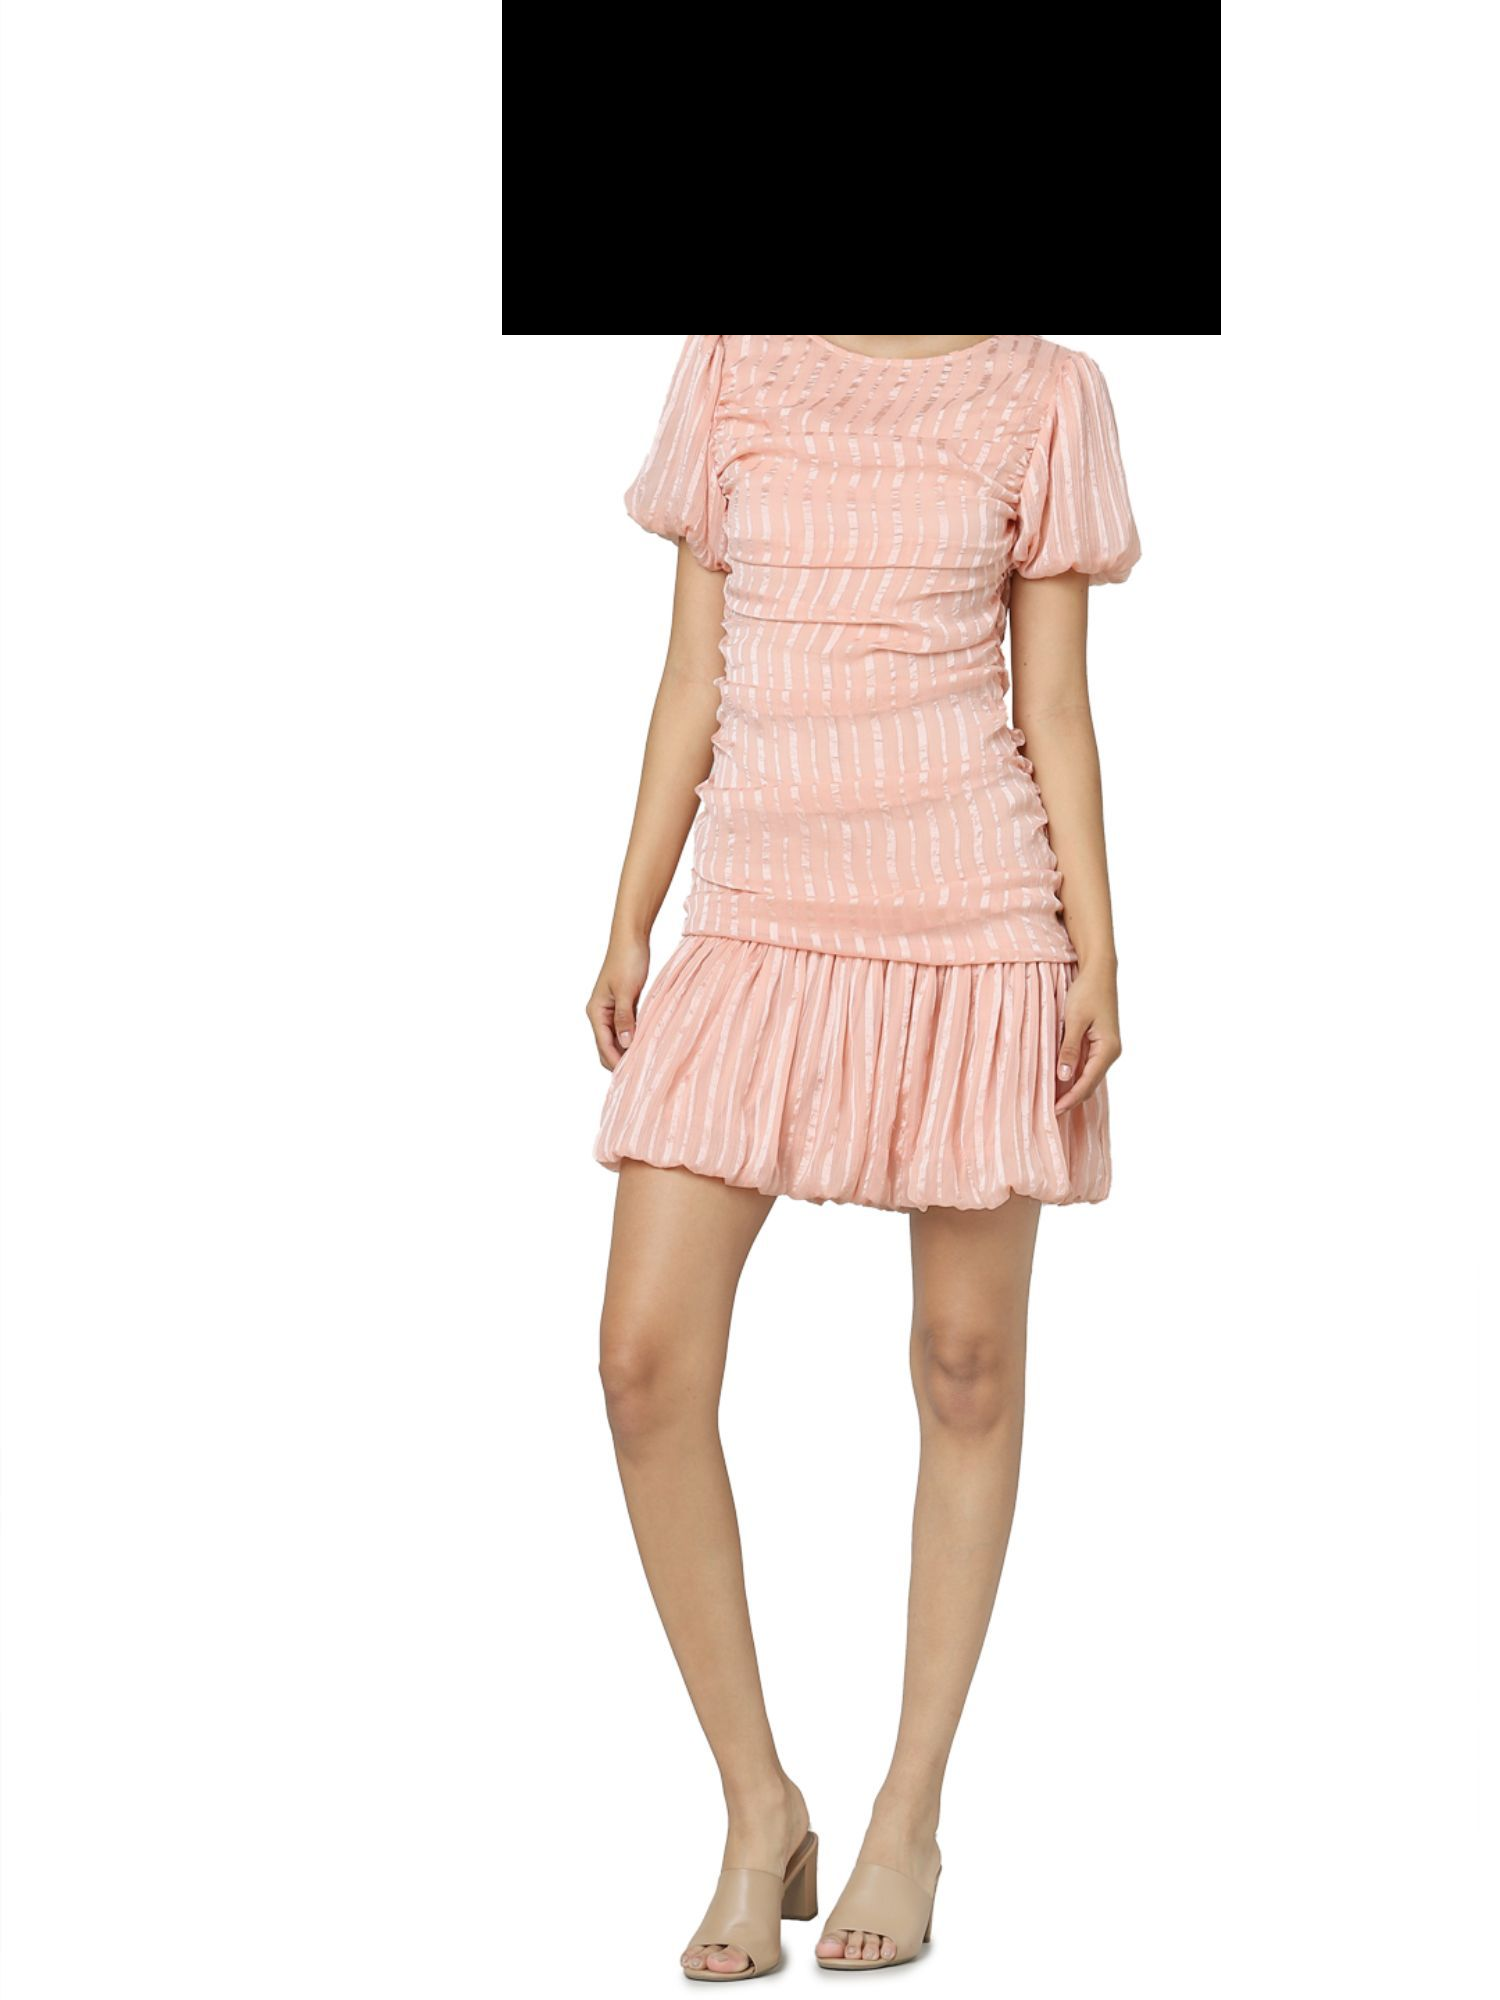

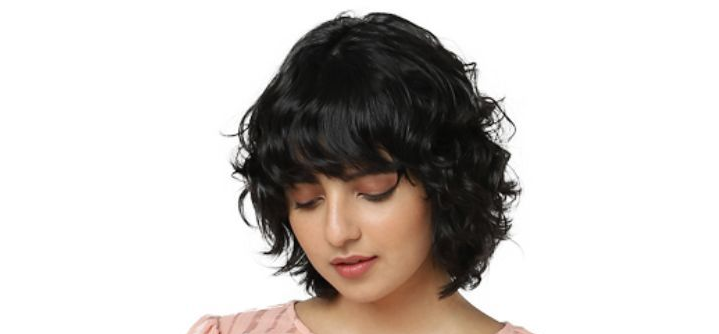


0: 640x480 1 FACE, 89.9ms
Speed: 1.9ms preprocess, 89.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 FACE, 89.6ms
Speed: 1.9ms preprocess, 89.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


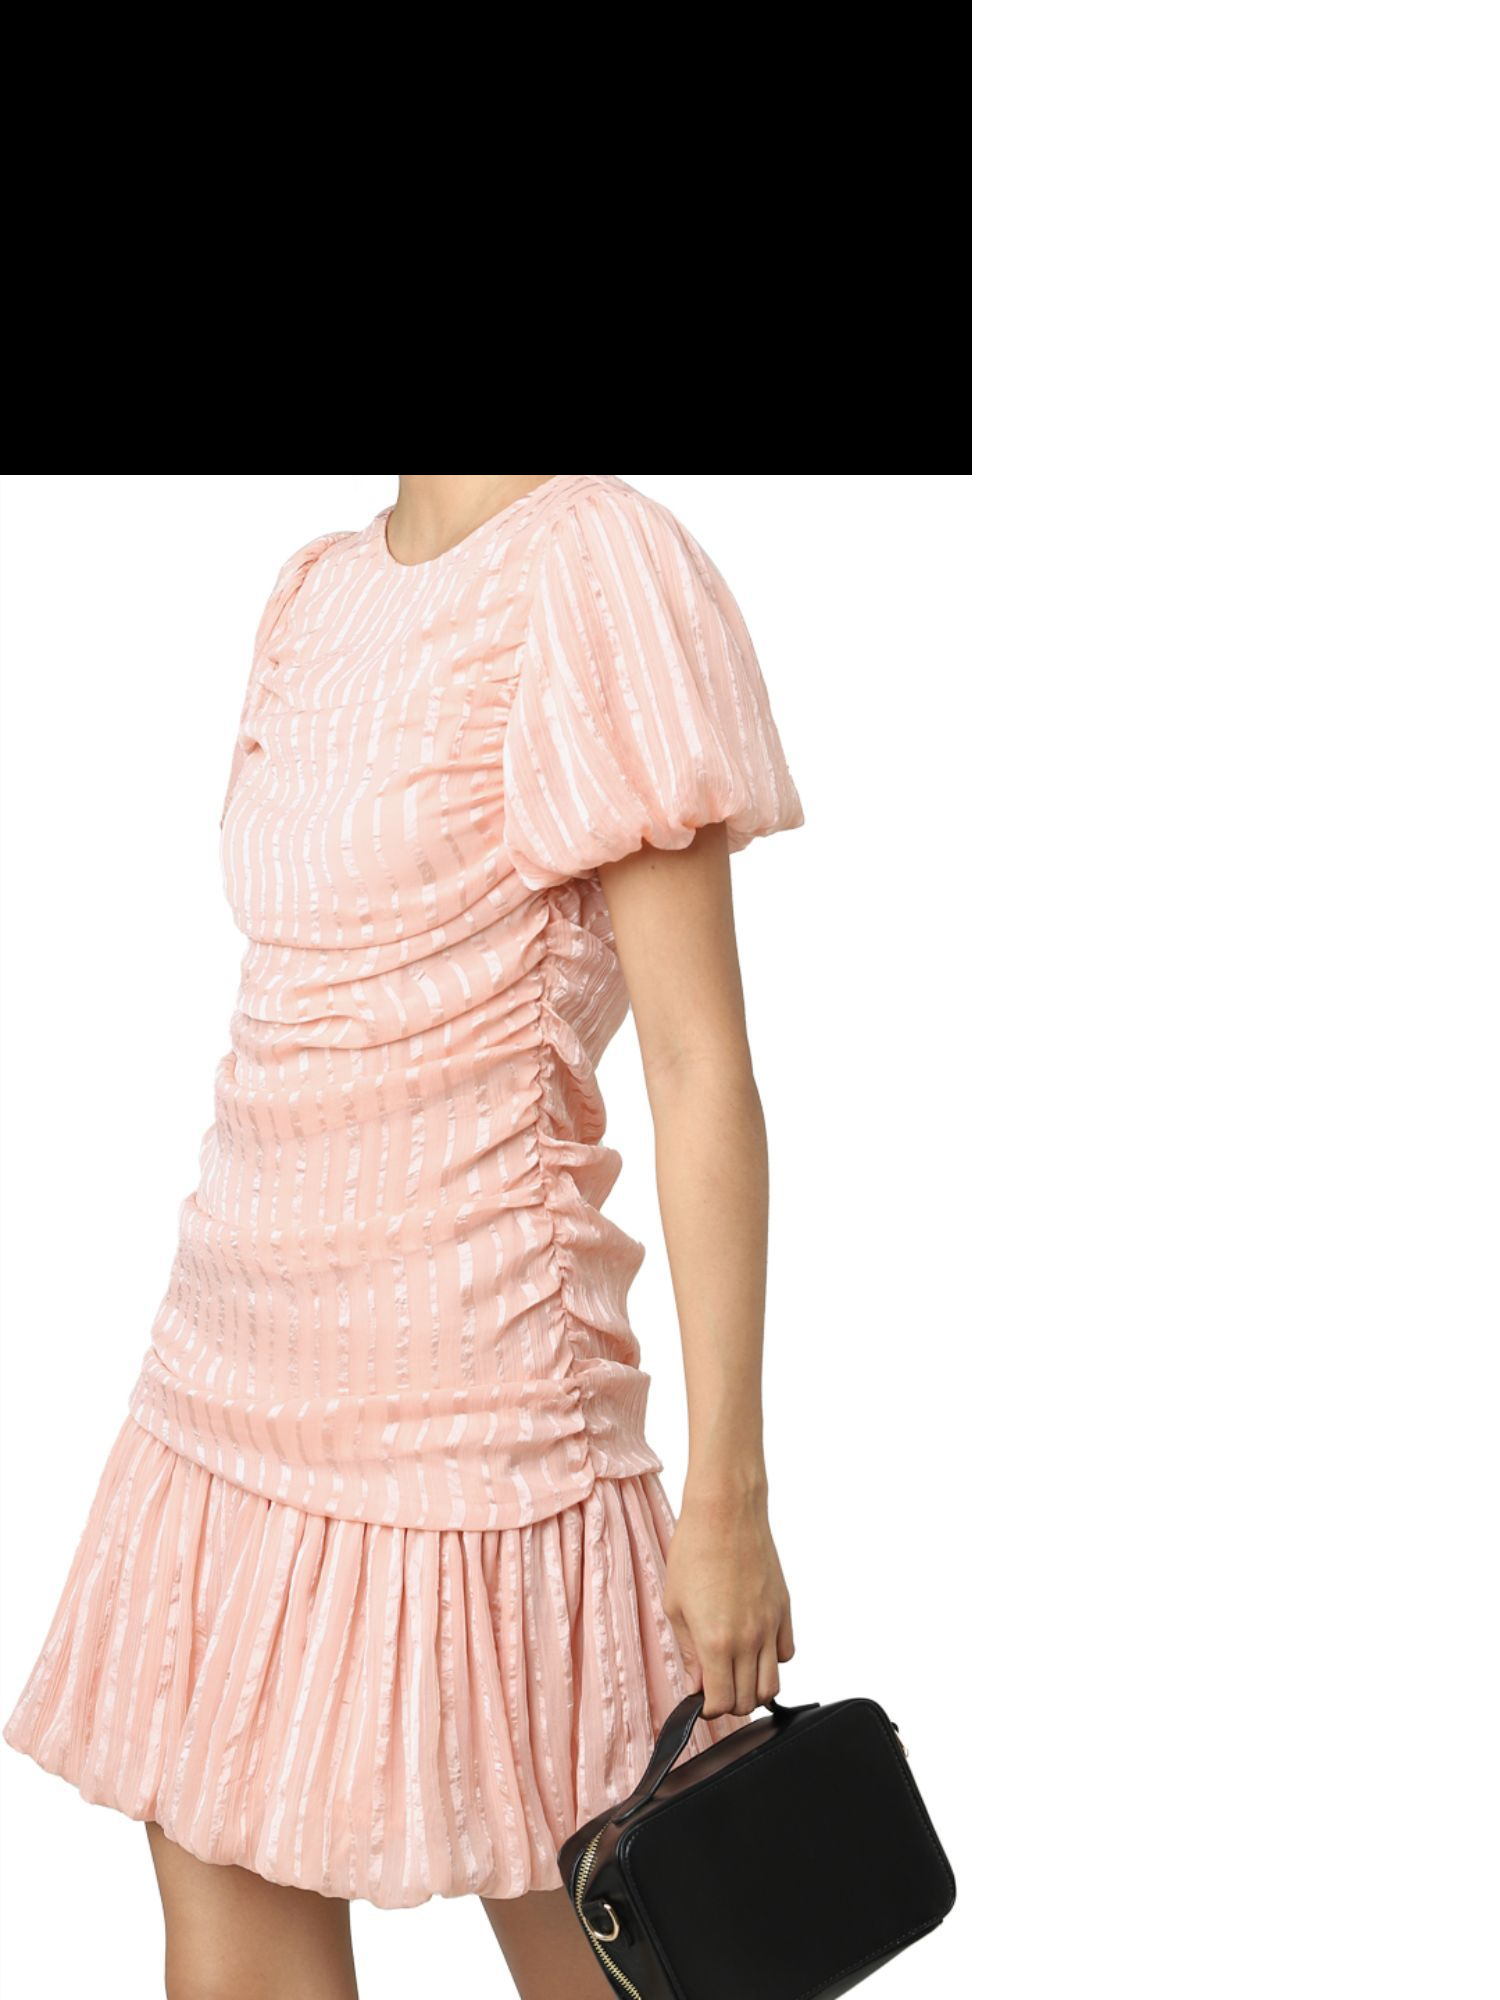

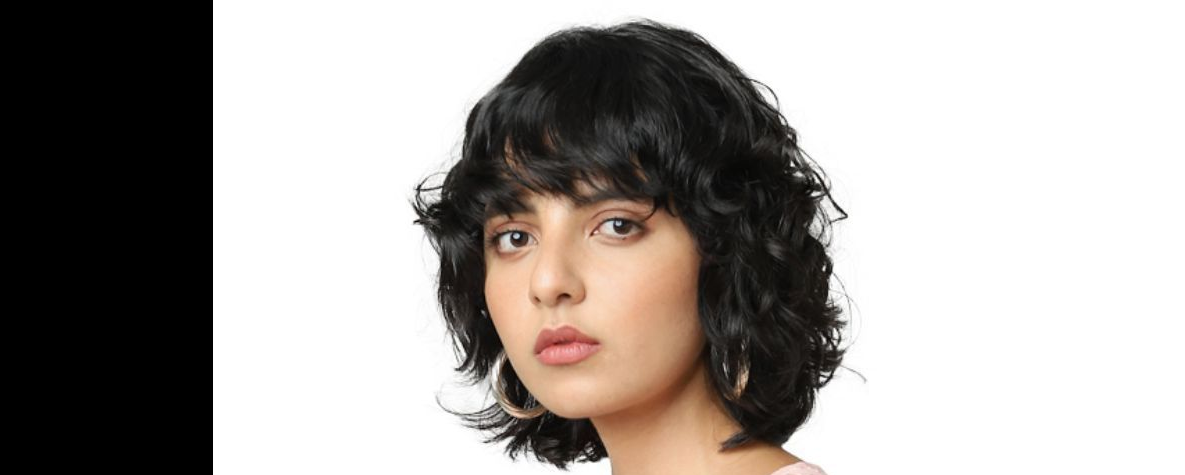


0: 640x480 1 FACE, 89.7ms
Speed: 2.0ms preprocess, 89.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


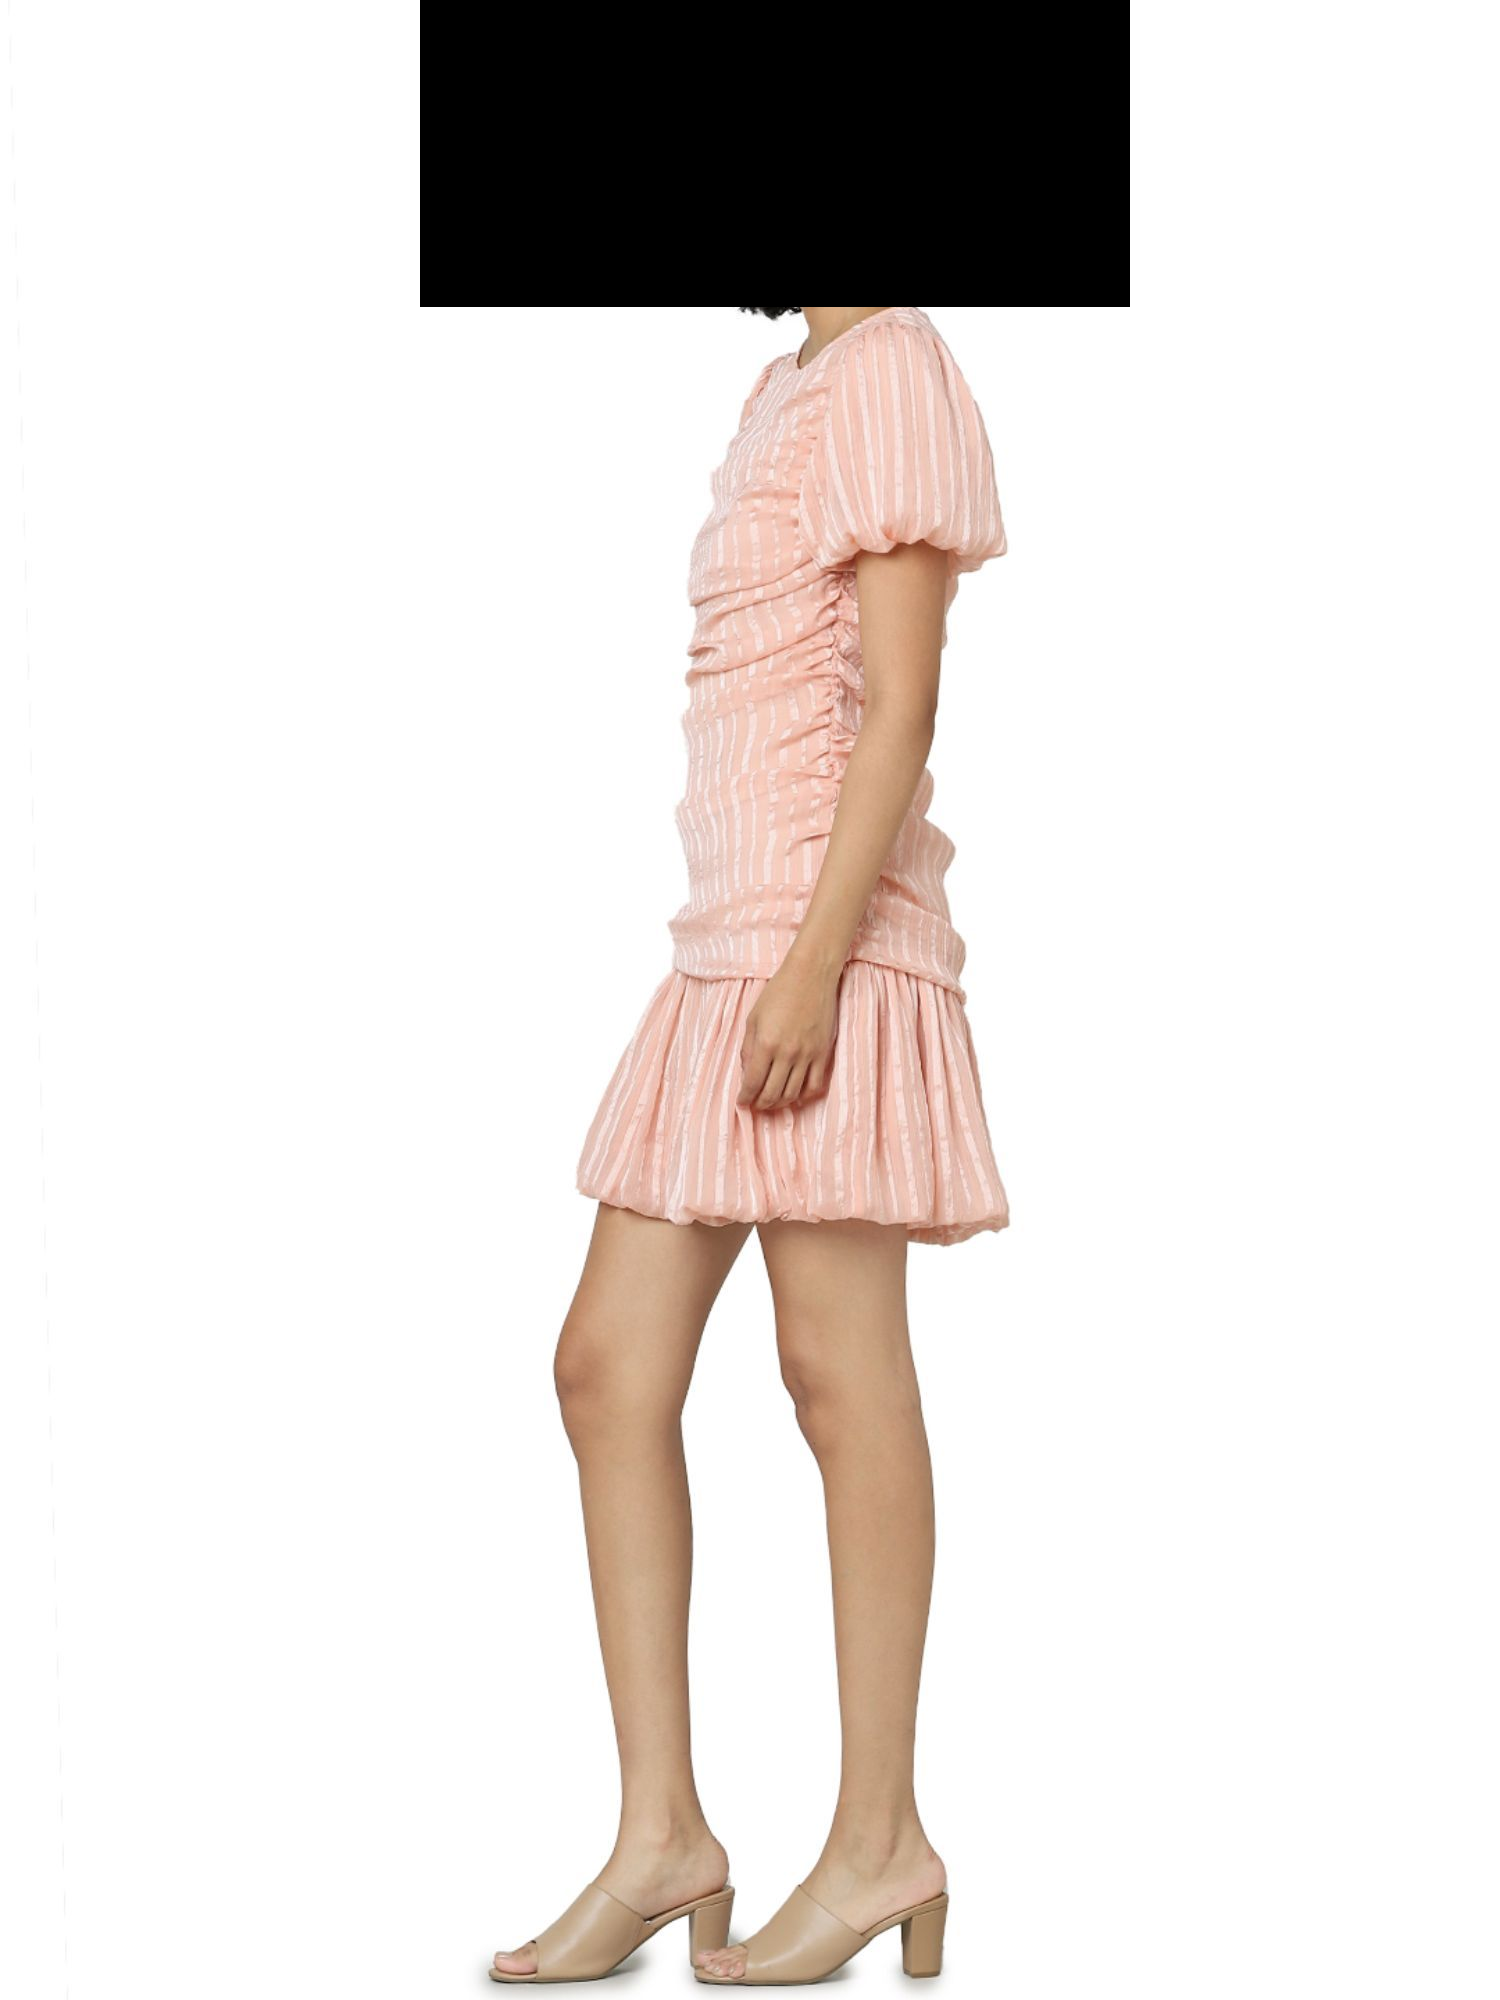

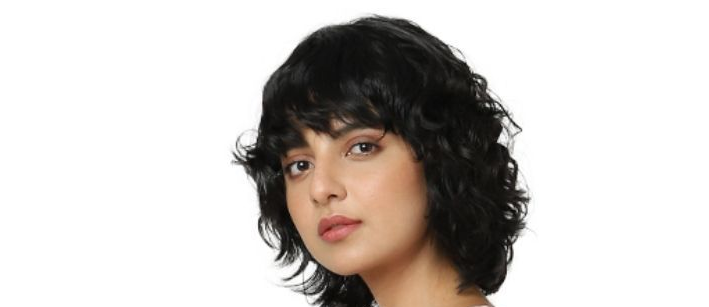


0: 640x480 1 FACE, 89.4ms
Speed: 1.9ms preprocess, 89.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


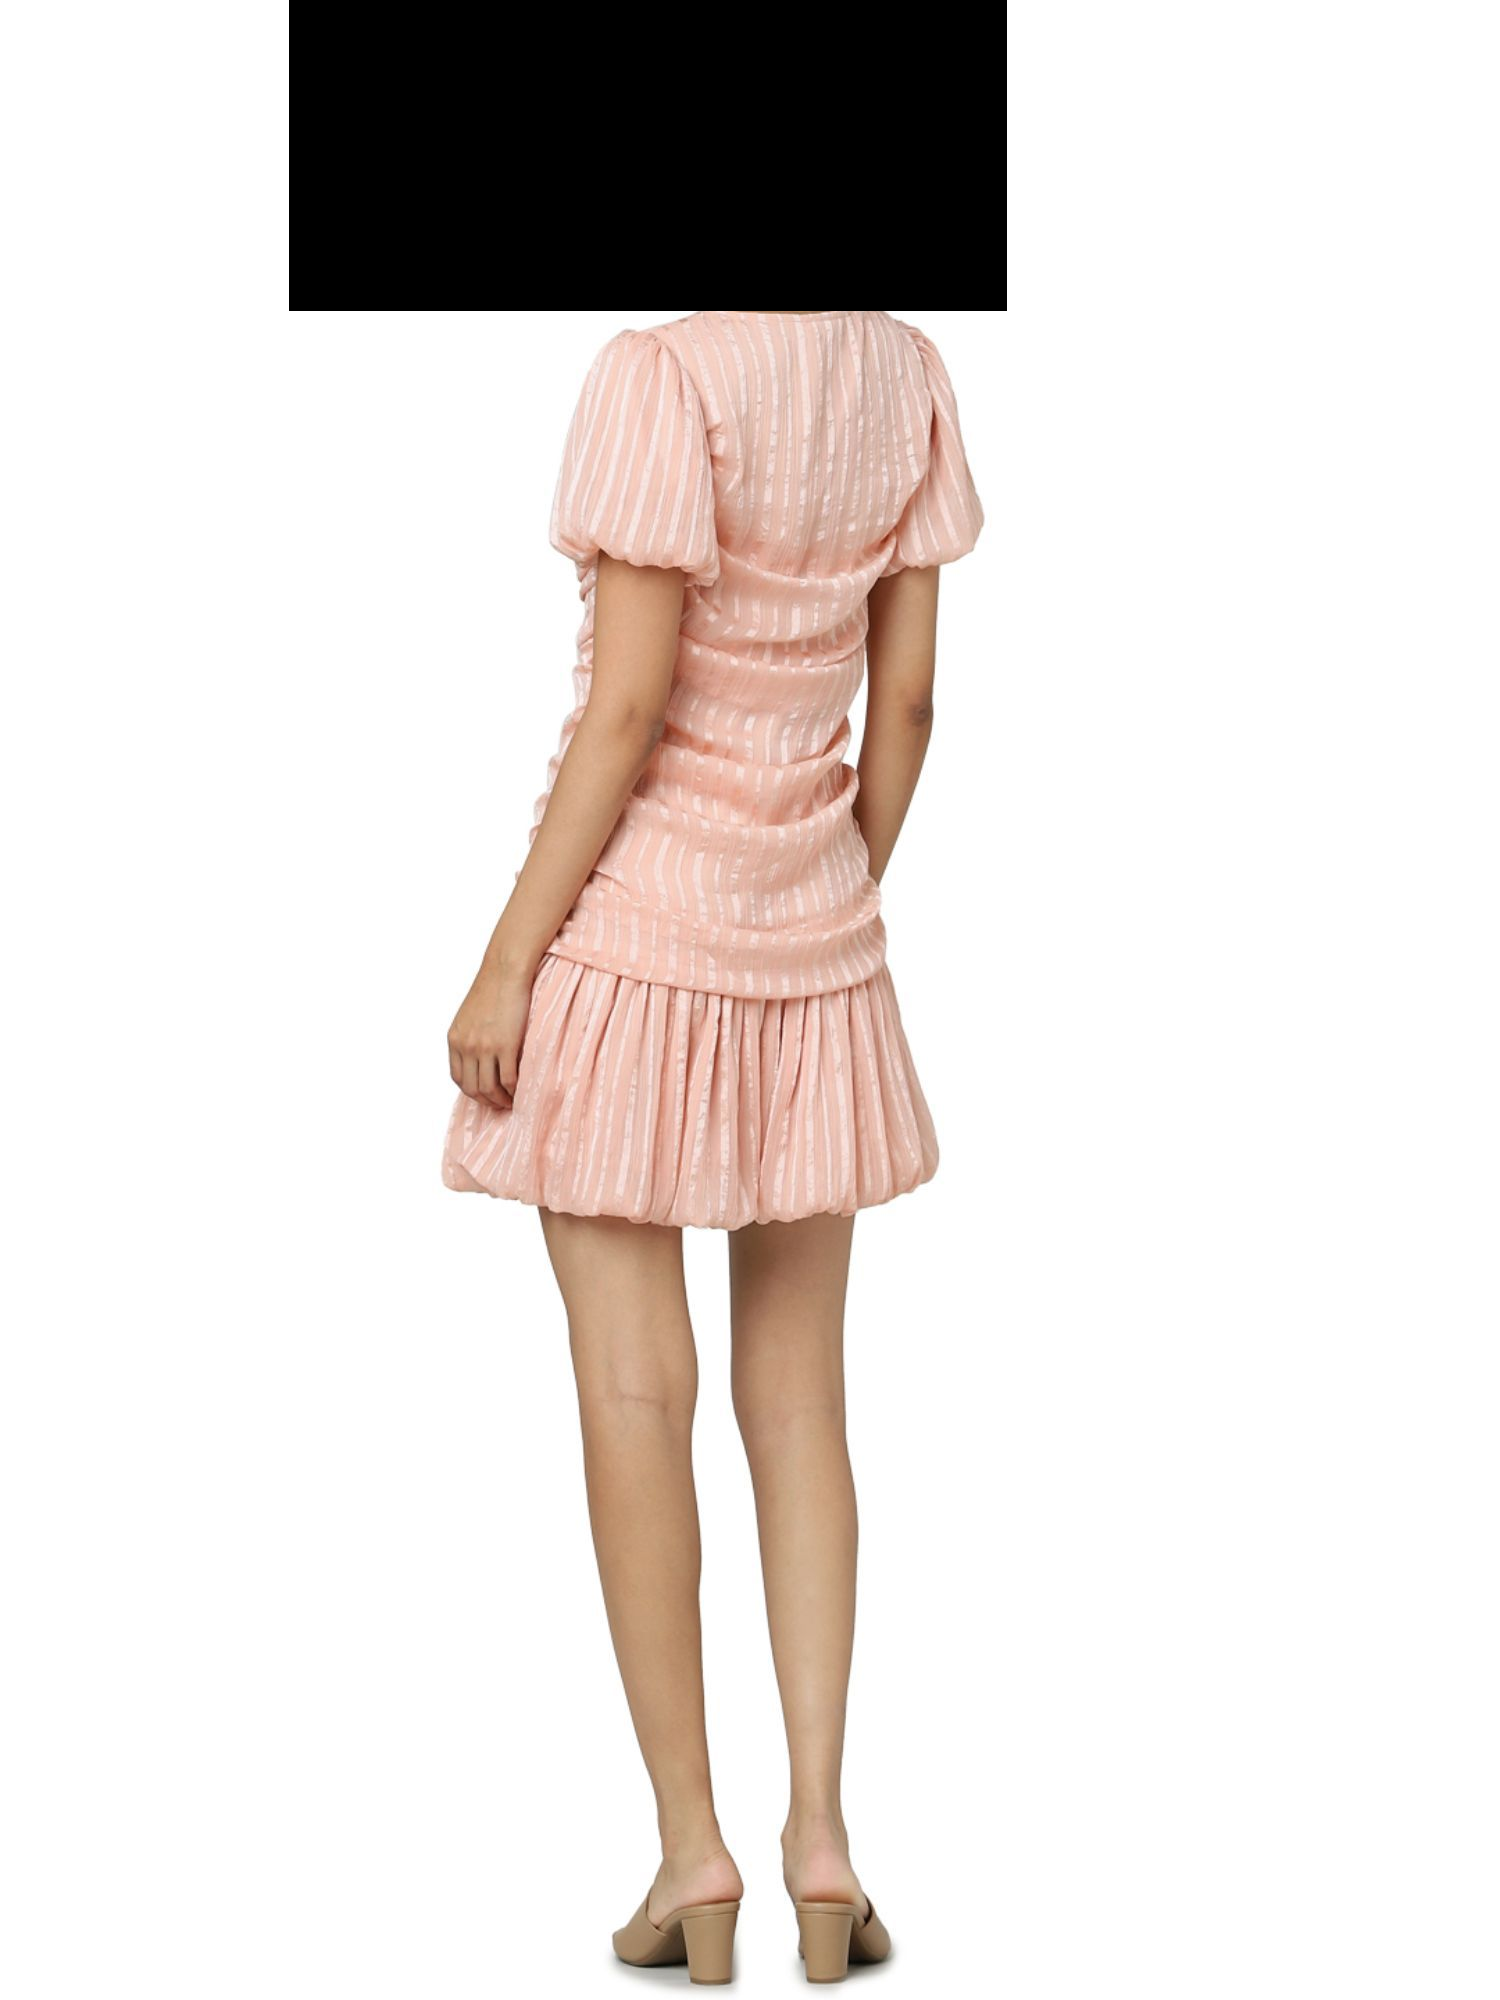

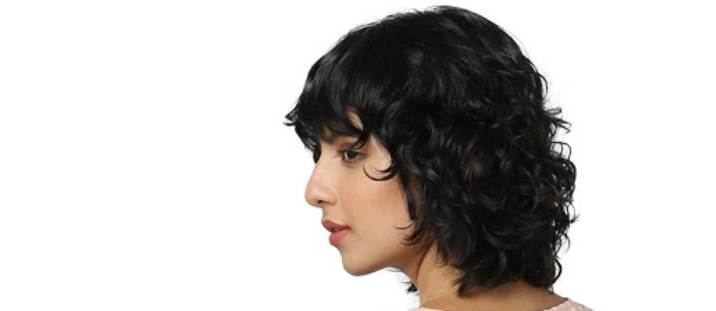

In [45]:
for imgpath in images:
    image= Image.open(imgpath)
    bboxes=detect_faces(image)
    if len(bboxes)>1:
        continue
    bbox=bboxes[0]
    if not checkvertical(bbox):
        continue
    bbox=make_square(bbox)
    # display(draw_bbox_on_image(image,bbox))
    cropped=crop_face(image,bbox)
    painted=draw_on_bbox(image,bbox)
    